In [ ]:
#CONFIG
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
import umap
import json
import base64
import io
import os
from PIL import Image
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Dense
from tensorflow.keras.callbacks import EarlyStopping

# --- CONFIGURAZIONE ---
CONFIG = {
    # OPZIONE A: Dataset Keras ('mnist', 'fashion_mnist')
    # OPZIONE B: 'custom_folder' (per dataset Kaggle organizzati in cartelle)
    'DATASET_NAME': 'fashion_mnist', 
    
    # Se usi 'custom_folder', metti qui il percorso (es: '/kaggle/input/fruits/train')
    'DATASET_PATH': '', 
    
    # Dimensioni Immagine (Se usi custom, verranno ridimensionate a questo)
    'IMG_HEIGHT': 28,
    'IMG_WIDTH': 28,
    'CHANNELS': 1,     # 1 per bianco/nero, 3 per colori RGB
    
    'LATENT_DIM': 32,      
    'EPOCHS': 20,          
    'BATCH_SIZE': 128,     
    'N_NEIGHBORS': 15,     
    'MIN_DIST': 0.1,       
    'SAMPLE_LIMIT': 30000, # Max punti per UMAP (occhio che con dataset grandi UMAP è lento)
    'OUTPUT_FILENAME': 'latent_map_data.json'
}

# --- DIZIONARI DI BACKUP PER I DATASET PRECONFEZIONATI ---
# (Purtroppo questi dataset non contengono i nomi dentro i file, servono per forza)
FASHION_LABELS = {0: "T-shirt/top", 1: "Pantalone", 2: "Pullover", 3: "Vestito", 4: "Cappotto", 5: "Sandalo", 6: "Camicia", 7: "Sneaker", 8: "Borsa", 9: "Stivaletto"}
MNIST_LABELS = {i: str(i) for i in range(10)}

def load_dataset_universal(config):
    name = config['DATASET_NAME']
    h, w, c = config['IMG_HEIGHT'], config['IMG_WIDTH'], config['CHANNELS']
    
    print(f"🔄 Caricamento dataset: {name}...")

    # --- CASO 1: DATASET PRECONFEZIONATI (MNIST/FASHION) ---
    if "mnist" in name :
        if name == 'mnist':
            (x_train, y_train), (x_test, y_test) = mnist.load_data()
            labels_map = MNIST_LABELS
        else:
            (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
            labels_map = FASHION_LABELS
            
        # Normalizzazione e Reshape
        # Uniamo train e test per avere più dati, poi tagliamo al SAMPLE_LIMIT
        X_all = np.concatenate([x_train, x_test])
        y_all = np.concatenate([y_train, y_test])
        
        X_all = X_all.astype('float32') / 255.
        X_all = np.reshape(X_all, (len(X_all), h, w, c)) # Usa canali config
        
        # Prendiamo solo i primi N campioni
        X_final = X_all[:config['SAMPLE_LIMIT']]
        y_final = y_all[:config['SAMPLE_LIMIT']]
        
        return X_final, y_final, labels_map

    # --- CASO 2: DATASET KAGGLE (CARTELLE) ---
    elif name == 'custom_folder':
        path = config['DATASET_PATH']
        if not os.path.exists(path):
            raise ValueError(f"❌ Errore: Il percorso {path} non esiste!")

        print(f"📂 Leggo le classi dalla cartella: {path}")
        
        # Keras fa la magia: legge le cartelle e crea le classi
        dataset = image_dataset_from_directory(
            path,
            labels='inferred',       # Legge i nomi delle sottocartelle!
            label_mode='int',        # Converte in 0, 1, 2...
            color_mode='grayscale' if c == 1 else 'rgb',
            batch_size=config['BATCH_SIZE'],
            image_size=(h, w),
            shuffle=True,
            seed=42
        )

        # Estraiamo i nomi delle classi AUTOMATICAMENTE
        class_names = dataset.class_names
        labels_map = {i: name for i, name in enumerate(class_names)}
        print(f"✅ Classi trovate: {labels_map}")

        # Convertiamo il dataset TensorFlow in Numpy array (per UMAP)
        # (Prendiamo solo i dati necessari fino al limit)
        print("Convertendo in Numpy per UMAP...")
        images_list = []
        labels_list = []
        
        count = 0
        for images, labels in dataset:
            images_list.append(images.numpy())
            labels_list.append(labels.numpy())
            count += len(images)
            if count >= config['SAMPLE_LIMIT']:
                break
        
        X_final = np.concatenate(images_list)[:config['SAMPLE_LIMIT']]
        y_final = np.concatenate(labels_list)[:config['SAMPLE_LIMIT']]
        
        # Normalizzazione (0-255 -> 0-1)
        X_final = X_final.astype('float32') / 255.
        
        return X_final, y_final, labels_map

    else:
        raise ValueError("Dataset sconosciuto. Usa 'mnist', 'fashion_mnist' o 'custom_folder'")

# --- ESECUZIONE ---
X_data, y_labels, LABELS_MAP = load_dataset_universal(CONFIG)

print(f"✅ Dati pronti!")
print(f"Shape Dati: {X_data.shape}")
print(f"Esempio Etichette: {list(LABELS_MAP.values())[:5]}")

In [ ]:
!pip install umap-learn==0.5.3

In [8]:
#CONFIGURAZIONE E CARICAMENTO 
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
import umap
import json
import base64
import io
import os
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # IMPORTANTE!
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Dense
from tensorflow.keras.callbacks import EarlyStopping

# --- CONFIGURAZIONE ---
CONFIG = {
    'DATASET_NAME': 'fashion_mnist', 
    'DATASET_PATH': '', 
    
    'IMG_HEIGHT': 28,
    'IMG_WIDTH': 28,
    'CHANNELS': 1,
    
    'LATENT_DIM': 32,      
    'EPOCHS': 20,          
    'BATCH_SIZE': 128,     
    'N_NEIGHBORS': 15,     
    'MIN_DIST': 0.1,       
    'SAMPLE_LIMIT': 70000, # Max punti TOTALI da caricare
    'OUTPUT_FILENAME': 'latent_map_data.json'
}

FASHION_LABELS = {0: "T-shirt/top", 1: "Pantalone", 2: "Pullover", 3: "Vestito", 4: "Cappotto", 5: "Sandalo", 6: "Camicia", 7: "Sneaker", 8: "Borsa", 9: "Stivaletto"}
MNIST_LABELS = {i: str(i) for i in range(10)}

def load_dataset_universal(config):
    name = config['DATASET_NAME']
    h, w, c = config['IMG_HEIGHT'], config['IMG_WIDTH'], config['CHANNELS']
    
    print(f"🔄 Caricamento dataset: {name}...")

    X_final = None
    y_final = None
    labels_map = {}

    # --- CASO 1: MNIST/FASHION ---
    if name in ['mnist', 'fashion_mnist']:
        if name == 'mnist':
            (x_tr, y_tr), (x_te, y_te) = mnist.load_data()
            labels_map = MNIST_LABELS
        else:
            (x_tr, y_tr), (x_te, y_te) = fashion_mnist.load_data()
            labels_map = FASHION_LABELS
            
        X_all = np.concatenate([x_tr, x_te])
        y_all = np.concatenate([y_tr, y_te])
        
        X_all = X_all.astype('float32') / 255.
        X_all = np.reshape(X_all, (len(X_all), h, w, c))
        
        # Tagliamo al limite configurato
        X_final = X_all[:config['SAMPLE_LIMIT']]
        y_final = y_all[:config['SAMPLE_LIMIT']]

    # --- CASO 2: CUSTOM FOLDER ---
    elif name == 'custom_folder':
        path = config['DATASET_PATH']
        if not os.path.exists(path):
            raise ValueError(f"❌ Errore: Il percorso {path} non esiste!")

        dataset = image_dataset_from_directory(
            path, labels='inferred', label_mode='int',
            color_mode='grayscale' if c == 1 else 'rgb',
            batch_size=config['BATCH_SIZE'], image_size=(h, w), shuffle=True, seed=42
        )

        class_names = dataset.class_names
        labels_map = {i: name for i, name in enumerate(class_names)}
        
        images_list = []
        labels_list = []
        count = 0
        for images, labels in dataset:
            images_list.append(images.numpy())
            labels_list.append(labels.numpy())
            count += len(images)
            if count >= config['SAMPLE_LIMIT']:
                break
        
        X_final = np.concatenate(images_list)[:config['SAMPLE_LIMIT']]
        y_final = np.concatenate(labels_list)[:config['SAMPLE_LIMIT']]
        X_final = X_final.astype('float32') / 255.

    return X_final, y_final, labels_map

# --- ESECUZIONE E SPLIT DEI DATI ---
# 1. Carichiamo TUTTI i dati (limitati a SAMPLE_LIMIT)
X_total, y_total, LABELS_MAP = load_dataset_universal(CONFIG)

# 2. Li dividiamo: 80% per addestrare l'Autoencoder (x_train), 20% per testare (x_test)
# NOTA: Useremo x_test ANCHE per UMAP e la visualizzazione finale
x_train, x_test, y_train, y_test = train_test_split(X_total, y_total, test_size=0.2, random_state=42)

# 3. Variabili per le celle successive (per compatibilità col vecchio codice)
# X_data e y_labels saranno usati per UMAP e l'export
X_data = x_test 
y_labels = y_test

print(f"✅ Dati pronti!")
print(f"Totale caricato: {len(X_total)}")
print(f"Dati Training Autoencoder: {x_train.shape}")
print(f"Dati Visualizzazione (UMAP): {X_data.shape}")
print(f"Esempio Etichette: {list(LABELS_MAP.values())[:5]}")

🔄 Caricamento dataset: fashion_mnist...
✅ Dati pronti!
Totale caricato: 70000
Dati Training Autoencoder: (56000, 28, 28, 1)
Dati Visualizzazione (UMAP): (14000, 28, 28, 1)
Esempio Etichette: ['T-shirt/top', 'Pantalone', 'Pullover', 'Vestito', 'Cappotto']


In [4]:
#AUTOENCODER
# =============================================================================

print(f"Costruzione Autoencoder con spazio latente {CONFIG['LATENT_DIM']}D...")

# Encoder
input_img = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x) # Output: 7x7x8
x = Flatten()(x)
latent_vector = Dense(CONFIG['LATENT_DIM'], activation='relu')(x) # Layer Latente Dinamico

# Decoder
x_decoded = Dense(7 * 7 * 8, activation='relu')(latent_vector)
x_decoded = Reshape((7, 7, 8))(x_decoded)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x_decoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded_img = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Modelli
autoencoder = Model(input_img, decoded_img)
encoder = Model(input_img, latent_vector) # Serve per estrarre il latente
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Costruzione Autoencoder con spazio latente 32D...


In [5]:
# Addestramento
print("Inizio Addestramento...")
history = autoencoder.fit(
    x_train, x_train,
    epochs=50,
    batch_size=CONFIG['BATCH_SIZE'],
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=1
)
"""
history = autoencoder.fit(
    x_train, x_train,
    epochs=CONFIG['EPOCHS'],
    batch_size=CONFIG['BATCH_SIZE'],
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=1
)"""
print("Addestramento completato.")

Inizio Addestramento...
Epoch 1/50


I0000 00:00:1764555088.596197     125 service.cc:148] XLA service 0x7b6890006b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764555088.596799     125 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764555088.596816     125 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764555088.999267     125 cuda_dnn.cc:529] Loaded cuDNN version 90300


46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6437

I0000 00:00:1764555091.477353     125 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - loss: 0.6218 - val_loss: 0.4110
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3777 - val_loss: 0.3368
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3281 - val_loss: 0.3223
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3188 - val_loss: 0.3155
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3103 - val_loss: 0.3111
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3074 - val_loss: 0.3088
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3075 - val_loss: 0.3060
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3024 - val_loss: 0.3045
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3011 - val_loss: 0.3024
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2980 - val_loss: 0.3007
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2960 - val_loss: 0.2994
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2965 - val_loss: 0.2982

In [1]:
# FIX DEFINITIVO VERSIONI
# Rimuoviamo le versioni che litigano
!pip uninstall -y umap-learn scikit-learn

# Installiamo l'ultima versione di UMAP (che ha fixato quel bug) 
# e una versione di Scikit-learn che sappiamo essere compatibile al 100%
!pip install umap-learn==0.5.7 scikit-learn==1.2.2

Found existing installation: umap-learn 0.5.9.post2
Uninstalling umap-learn-0.5.9.post2:
  Successfully uninstalled umap-learn-0.5.9.post2
Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 78.0 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


In [7]:

import numpy as np
import matplotlib.pyplot as plt
import umap
import json
import base64
import io
import os
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # IMPORTANTE!
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Dense
from tensorflow.keras.callbacks import EarlyStopping


Generazione spazio latente...
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Latente generato. Shape: (2000, 32)
Esecuzione UMAP...


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


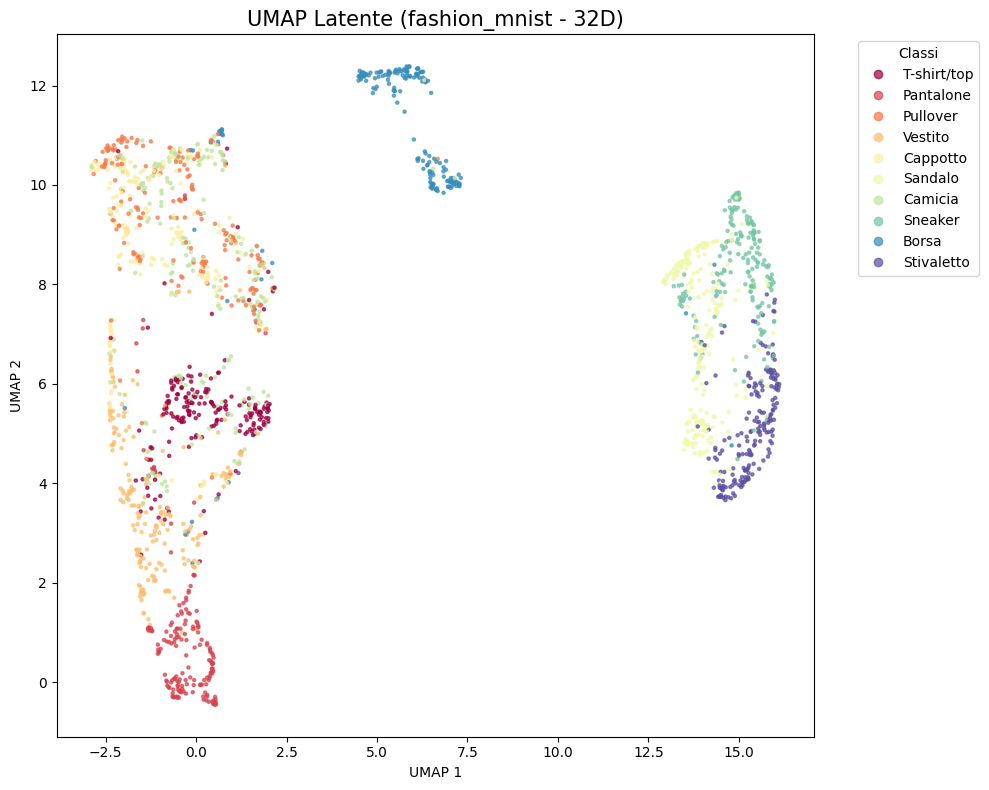

In [6]:
#ESTRAZIONE LATENTE E UMAP
# (Genera i vettori latenti e calcola la mappa 2D)
# =============================================================================

print("Generazione spazio latente...")
X_latent = encoder.predict(X_data)
print(f"Latente generato. Shape: {X_latent.shape}")

print("Esecuzione UMAP...")
"""
reducer_latent = umap.UMAP(
    n_neighbors=6,
    min_dist=0.03,
    n_components=2,
    random_state=42
)
"""
reducer_latent = umap.UMAP(
    n_neighbors=CONFIG['N_NEIGHBORS'],
    min_dist=CONFIG['MIN_DIST'],
    n_components=2,
    random_state=42
)
embedding_latent = reducer_latent.fit_transform(X_latent)

# Plot statico per controllo rapido
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embedding_latent[:, 0],
    embedding_latent[:, 1],
    c=y_labels,
    cmap='Spectral',
    s=5,
    alpha=0.7
)
plt.title(f"UMAP Latente ({CONFIG['DATASET_NAME']} - {CONFIG['LATENT_DIM']}D)", fontsize=15)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Legenda con nomi veri (se disponibili)
handles, _ = scatter.legend_elements(prop="colors")
legend_labels = [LABELS_MAP[i] for i in range(len(handles))]
plt.legend(handles, legend_labels, title="Classi", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# =============================================================================
# CELLA 5: ESPORTAZIONE DIRETTA PER IL WEB (data.js)
# (Crea il file JS pronto all'uso, senza modifiche manuali)
# =============================================================================

import json
import base64
import io
import numpy as np
from PIL import Image

# Nome del file finale (lo chiamiamo già .js così non devi rinominarlo)
FINAL_FILENAME = 'data.js' 

print(f"--- INIZIO ESPORTAZIONE DATI SU {FINAL_FILENAME} ---")

data_export_list = []

# Usiamo il limite impostato nella config o il numero totale di punti disponibili
limit = min(CONFIG['SAMPLE_LIMIT'], len(embedding_latent))

for i in range(limit):
    
    # 1. Immagine Thumbnail (Base64)
    # Gestisce sia grayscale (28,28) che RGB (28,28,3)
    img_array = X_data[i].squeeze() 
    
    # Se è grayscale e squeeze ha tolto l'ultima dim, va bene. 
    # Se è RGB, squeeze non toglie il canale colore.
    
    # Convertiamo in uint8 (0-255)
    img_uint8 = (img_array * 255).astype(np.uint8)
    pil_img = Image.fromarray(img_uint8)
    
    buffer = io.BytesIO()
    pil_img.save(buffer, format="PNG")
    img_base64 = base64.b64encode(buffer.getvalue()).decode('utf-8')
    img_data_uri = f"data:image/png;base64,{img_base64}"

    # 2. Vettore Latente
    latent_vec = np.round(X_latent[i], 4).tolist()

    # 3. Etichetta
    # Gestiamo il caso in cui y_labels potrebbe non essere ancora un intero
    label_idx = int(y_labels[i]) if isinstance(y_labels[i], (int, np.integer, float, np.floating)) else i
    
    # Recuperiamo il nome se esiste nella mappa, altrimenti usiamo il numero
    try:
        label_name = LABELS_MAP[label_idx]
    except:
        label_name = str(label_idx)

    # 4. Creazione Oggetto
    point_data = {
        "id": i,
        "label_index": label_idx,
        "label_name": label_name,
        "umap_x": round(float(embedding_latent[i, 0]), 3),
        "umap_y": round(float(embedding_latent[i, 1]), 3),
        "latent_vector": latent_vec,
        "image_base64": img_data_uri
    }
    
    data_export_list.append(point_data)

# --- SALVATAGGIO SPECIALE ---
# Invece di salvare un JSON puro, salviamo un file JavaScript valido.
# Scriviamo manualmente "const myData = " prima del JSON.

json_string = json.dumps(data_export_list)
js_content = f"const myData = {json_string};"

with open(FINAL_FILENAME, 'w') as f:
    f.write(js_content)

print(f"✅ Esportazione completata!")
print(f"👉 Scarica il file '{FINAL_FILENAME}' da Kaggle.")
print(f"👉 Mettilo nella cartella del tuo sito accanto a index.html.")
print(f"👉 Apri index.html (doppio click) e funziona subito.")

In [ ]:
# --- PULIZIA RADICALE ---
# Disinstalliamo le librerie GPU che causano il conflitto
# (Il -y serve per dire "sì" a tutte le conferme)
!pip uninstall -y cudf cugraph cuml cuspatial cuproj dask-cudf pynvml rmab

# --- INSTALLAZIONE DATASHADER ---
!pip install datashader colorcet

# --- IMPORT E FIX ---
import os
# Doppia sicurezza: diciamo a Python di ignorare qualsiasi residuo di CUDA per Datashader
os.environ['RAPIDS_NO_INITIALIZE'] = '1' 
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import datashader as ds
import datashader.transfer_functions as tf
from datashader.utils import export_image
import colorcet as cc
import pandas as pd
import matplotlib.pyplot as plt

print("--- GENERAZIONE CYBERPUNK NEON (CPU MODE) ---")

# --- (Il resto del codice è identico a prima) ---
# 1. Prepariamo i dati
df = pd.DataFrame(embedding_latent, columns=['x', 'y'])
df['label'] = y_labels.astype('category') 

# 2. Configurazioni Colori Neon
neon_colors = [
    "#FF00FF", "#00FFFF", "#00FF00", "#FFFF00", "#FF0000", 
    "#7B68EE", "#FF8C00", "#00BFFF", "#FF1493", "#ADFF2F"
]

# 3. Creiamo la Tela
canvas = ds.Canvas(plot_width=1600, plot_height=1600)

# 4. Aggregazione
agg = canvas.points(df, 'x', 'y', ds.count_cat('label'))

# 5. Rendering
img = tf.shade(agg, color_key=neon_colors, how='eq_hist')

# 6. Glow
img = tf.dynspread(img, threshold=0.5, max_px=4)

# 7. Sfondo Nero
img = tf.set_background(img, "black")

# 8. Salvataggio
print("Salvataggio immagine...")
export_image(img, "cyberpunk_map", background="black", export_path=".")

# 9. Visualizzazione
plt.figure(figsize=(12, 12))
plt.imshow(img.to_pil())
plt.axis('off')
plt.title("Latente Cyberpunk", color='white', backgroundcolor='black')
plt.show()

In [9]:
# =============================================================================
# CELLA COMPLETA: CONFIGURAZIONE, DATI FULL, AUTOENCODER POTENZIATO, UMAP & EXPORT
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
import umap
import json
import base64
import io
import os
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Dense, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- 1. CONFIGURAZIONE ---
CONFIG = {
    'DATASET_NAME': 'fashion_mnist', 
    'DATASET_PATH': '', 
    
    'IMG_HEIGHT': 28,
    'IMG_WIDTH': 28,
    'CHANNELS': 1,
    
    'LATENT_DIM': 32,      
    'EPOCHS': 50,          # Aumentato: diamogli tempo di imparare
    'BATCH_SIZE': 256,     # Aumentato: processiamo più dati insieme (più veloce su GPU)
    'N_NEIGHBORS': 15,     
    'MIN_DIST': 0.1,       
    'SAMPLE_LIMIT': None,  # None = USA TUTTO IL DATASET (70k immagini)
    'EXPORT_LIMIT': 10000, # Per UMAP e JSON ne usiamo solo 10k alla fine (per non appesantire il browser)
    'OUTPUT_FILENAME': 'data.js'
}

FASHION_LABELS = {0: "T-shirt/top", 1: "Pantalone", 2: "Pullover", 3: "Vestito", 4: "Cappotto", 5: "Sandalo", 6: "Camicia", 7: "Sneaker", 8: "Borsa", 9: "Stivaletto"}
MNIST_LABELS = {i: str(i) for i in range(10)}

# --- 2. CARICAMENTO DATI (LOGICA FULL) ---
def load_dataset_universal(config):
    name = config['DATASET_NAME']
    h, w, c = config['IMG_HEIGHT'], config['IMG_WIDTH'], config['CHANNELS']
    limit = config['SAMPLE_LIMIT']
    
    print(f"🔄 Caricamento dataset COMPLETO: {name}...")

    X_final = None
    y_final = None
    labels_map = {}

    if name in ['mnist', 'fashion_mnist']:
        if name == 'mnist':
            (x_tr, y_tr), (x_te, y_te) = mnist.load_data()
            labels_map = MNIST_LABELS
        else:
            (x_tr, y_tr), (x_te, y_te) = fashion_mnist.load_data()
            labels_map = FASHION_LABELS
            
        X_all = np.concatenate([x_tr, x_te])
        y_all = np.concatenate([y_tr, y_te])
        
        X_all = X_all.astype('float32') / 255.
        X_all = np.reshape(X_all, (len(X_all), h, w, c))
        
        if limit:
            X_final = X_all[:limit]
            y_final = y_all[:limit]
        else:
            X_final = X_all
            y_final = y_all

    elif name == 'custom_folder':
        # Logica per cartelle custom (rimasta uguale ma adattata al limite None)
        path = config['DATASET_PATH']
        if not os.path.exists(path): raise ValueError(f"❌ Errore path: {path}")
        dataset = image_dataset_from_directory(path, labels='inferred', label_mode='int', color_mode='grayscale' if c == 1 else 'rgb', batch_size=config['BATCH_SIZE'], image_size=(h, w), shuffle=True, seed=42)
        class_names = dataset.class_names
        labels_map = {i: name for i, name in enumerate(class_names)}
        images_list, labels_list = [], []
        for images, labels in dataset:
            images_list.append(images.numpy())
            labels_list.append(labels.numpy())
            if limit and len(images_list) * config['BATCH_SIZE'] >= limit: break
        X_final = np.concatenate(images_list)
        y_final = np.concatenate(labels_list)
        if limit: X_final, y_final = X_final[:limit], y_final[:limit]
        X_final = X_final.astype('float32') / 255.

    return X_final, y_final, labels_map

# Carichiamo TUTTO
X_total, y_total, LABELS_MAP = load_dataset_universal(CONFIG)

# Split Training (80%) / Validation (20%)
# Usiamo molti dati per il training così impara bene
x_train, x_val, y_train, y_val = train_test_split(X_total, y_total, test_size=0.2, random_state=42)

print(f"✅ Dati pronti per il training!")
print(f"Training set: {x_train.shape}")
print(f"Validation set: {x_val.shape}")


# --- 3. AUTOENCODER "DOPATO" (ARCHITETTURA MIGLIORATA) ---
print(f"🏗️ Costruzione Autoencoder Potenziato ({CONFIG['LATENT_DIM']}D)...")

input_img = Input(shape=(28, 28, 1))

# ENCODER (Più profondo e largo)
# Blocco 1
x = Conv2D(32, (3, 3), padding='same')(input_img) # Da 16 a 32 filtri
x = BatchNormalization()(x) # Aiuta a convergere prima
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Blocco 2
x = Conv2D(64, (3, 3), padding='same')(x) # Da 8 a 64 filtri! Molto più potente
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x) # Output 7x7x64

# Latente
x = Flatten()(x)
latent_vector = Dense(CONFIG['LATENT_DIM'], activation='relu', name="latent_layer")(x)

# DECODER (Simmetrico)
x = Dense(7 * 7 * 64, activation='relu')(latent_vector)
x = Reshape((7, 7, 64))(x)

# Blocco 2 Decoder
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)

# Blocco 1 Decoder
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)

# Output
decoded_img = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Modelli
autoencoder = Model(input_img, decoded_img)
encoder = Model(input_img, latent_vector)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Addestramento
print("🚀 Inizio Addestramento...")
# Callbacks: EarlyStopping (fermati se non migliori) e ReduceLROnPlateau (se ti blocchi, rallenta e impara meglio)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

history = autoencoder.fit(
    x_train, x_train,
    epochs=CONFIG['EPOCHS'],
    batch_size=CONFIG['BATCH_SIZE'],
    shuffle=True,
    validation_data=(x_val, x_val),
    callbacks=callbacks,
    verbose=1
)
print("🏁 Addestramento completato.")


# --- 4. PREPARAZIONE DATI PER VISUALIZZAZIONE ---
# Per UMAP ed Export non usiamo 70k punti (troppo lento in JS), ne prendiamo un sottoinsieme dal validation set
print(f"📉 Selezione di {CONFIG['EXPORT_LIMIT']} punti per la visualizzazione...")

# Prendiamo solo i primi N dal validation set (che la rete non ha mai visto in training, ottimo test)
X_viz = x_val[:CONFIG['EXPORT_LIMIT']]
y_viz = y_val[:CONFIG['EXPORT_LIMIT']]

print("🧠 Generazione spazio latente...")
X_latent = encoder.predict(X_viz)

print("🗺️ Esecuzione UMAP...")
reducer_latent = umap.UMAP(
    n_neighbors=CONFIG['N_NEIGHBORS'],
    min_dist=CONFIG['MIN_DIST'],
    n_components=2,
    random_state=42,
    n_jobs=-1 # Usa tutti i core della CPU
)
embedding_latent = reducer_latent.fit_transform(X_latent)


# --- 5. ESPORTAZIONE PER IL WEB (data.js) ---
print(f"💾 Esportazione dati su {CONFIG['OUTPUT_FILENAME']}...")

data_export_list = []
limit = len(embedding_latent)

for i in range(limit):
    # Immagine
    img_array = X_viz[i].squeeze()
    img_uint8 = (img_array * 255).astype(np.uint8)
    pil_img = Image.fromarray(img_uint8)
    buffer = io.BytesIO()
    pil_img.save(buffer, format="PNG")
    img_base64 = base64.b64encode(buffer.getvalue()).decode('utf-8')
    img_data_uri = f"data:image/png;base64,{img_base64}"

    # Latente
    latent_vec = np.round(X_latent[i], 4).tolist()

    # Label
    label_idx = int(y_viz[i]) if isinstance(y_viz[i], (int, np.integer, float, np.floating)) else i
    try: label_name = LABELS_MAP[label_idx]
    except: label_name = str(label_idx)

    point_data = {
        "id": i,
        "label_index": label_idx,
        "label_name": label_name,
        "umap_x": round(float(embedding_latent[i, 0]), 3),
        "umap_y": round(float(embedding_latent[i, 1]), 3),
        "latent_vector": latent_vec,
        "image_base64": img_data_uri
    }
    data_export_list.append(point_data)

# Scrittura file JS
json_string = json.dumps(data_export_list)
js_content = f"const myData = {json_string};"

with open(CONFIG['OUTPUT_FILENAME'], 'w') as f:
    f.write(js_content)

print(f"✅ TUTTO FATTO! Scarica '{CONFIG['OUTPUT_FILENAME']}' e mettilo nella cartella del sito.")

🔄 Caricamento dataset COMPLETO: fashion_mnist...
✅ Dati pronti per il training!
Training set: (56000, 28, 28, 1)
Validation set: (14000, 28, 28, 1)
🏗️ Costruzione Autoencoder Potenziato (32D)...
🚀 Inizio Addestramento...
Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - loss: 0.4125 - val_loss: 0.4188 - learning_rate: 0.0010
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.2918 - val_loss: 0.3183 - learning_rate: 0.0010
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.2846 - val_loss: 0.2819 - learning_rate: 0.0010
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2812 - val_loss: 0.2814 - learning_rate: 0.0010
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2796 - val_loss: 0.2784 - learning_rate: 0.0010
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2784 - val_loss: 0.2773 - learning_rate: 0.0010
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2773 - val_loss: 0.2767 - learning_rate: 0.0010
E

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


💾 Esportazione dati su data.js...
✅ TUTTO FATTO! Scarica 'data.js' e mettilo nella cartella del sito.


🔄 Preparazione dati per confronto su 20000 punti...
1️⃣ Calcolo UMAP sui Pixel Grezzi (784D)... (Questo sarà più lento)


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


2️⃣ Calcolo UMAP sullo Spazio Latente (32D)...


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


🎨 Disegno il confronto...


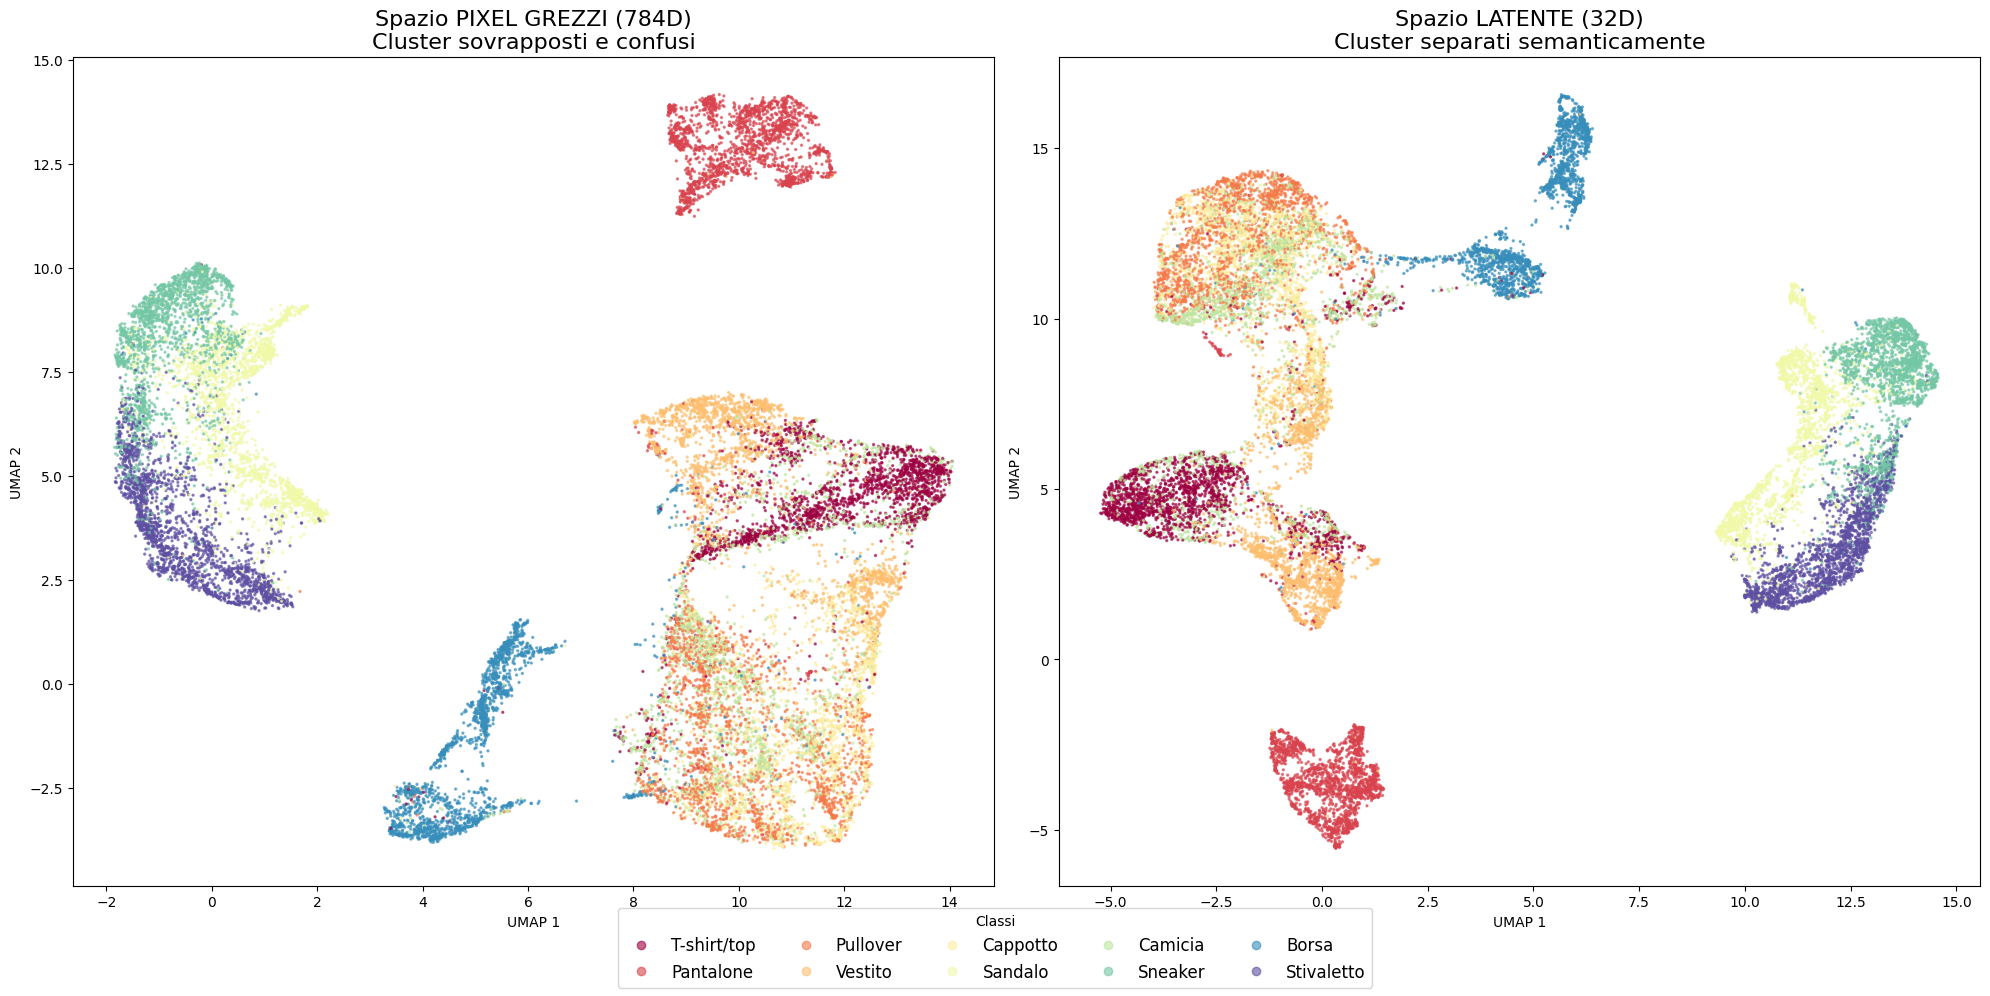

In [10]:
# =============================================================================
# CELLA SPECIALE: CONFRONTO RAW PIXELS vs LATENT SPACE
# (Dimostrazione scientifica dell'efficacia dell'Autoencoder)
# =============================================================================

import matplotlib.pyplot as plt
import umap
import numpy as np

# 1. CONFIGURAZIONE CONFRONTO
# Aumentiamo i punti per vedere meglio la densità
NUM_POINTS = 20000 

print(f"🔄 Preparazione dati per confronto su {NUM_POINTS} punti...")

# Usiamo i dati totali caricati prima (X_total, y_total)
# Assicuriamoci di non sforare la lunghezza massima
limit = min(NUM_POINTS, len(X_total))

X_sample = X_total[:limit]
y_sample = y_total[:limit]

# --- A. UMAP SUI DATI GREZZI (RAW PIXELS) ---
print("1️⃣ Calcolo UMAP sui Pixel Grezzi (784D)... (Questo sarà più lento)")
# Appiattiamo l'immagine da (28,28) a (784,)
X_raw_flat = X_sample.reshape((len(X_sample), -1))

reducer_raw = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42, n_jobs=-1)
embedding_raw = reducer_raw.fit_transform(X_raw_flat)


# --- B. UMAP SULLO SPAZIO LATENTE (AE FEATURES) ---
print("2️⃣ Calcolo UMAP sullo Spazio Latente (32D)...")
# Generiamo il latente fresco fresco
X_latent_sample = encoder.predict(X_sample, verbose=0)

reducer_latent = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42, n_jobs=-1)
embedding_latent = reducer_latent.fit_transform(X_latent_sample)


# --- C. VISUALIZZAZIONE AFFIANCATA ---
print("🎨 Disegno il confronto...")

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Mappa colori
cmap = 'Spectral'

# Plot 1: RAW
scatter1 = axes[0].scatter(
    embedding_raw[:, 0], 
    embedding_raw[:, 1], 
    c=y_sample, 
    cmap=cmap, 
    s=2, 
    alpha=0.6
)
axes[0].set_title(f'Spazio PIXEL GREZZI (784D)\nCluster sovrapposti e confusi', fontsize=16)
axes[0].set_xlabel('UMAP 1')
axes[0].set_ylabel('UMAP 2')

# Plot 2: LATENT
scatter2 = axes[1].scatter(
    embedding_latent[:, 0], 
    embedding_latent[:, 1], 
    c=y_sample, 
    cmap=cmap, 
    s=2, 
    alpha=0.6
)
axes[1].set_title(f'Spazio LATENTE (32D)\nCluster separati semanticamente', fontsize=16)
axes[1].set_xlabel('UMAP 1')
axes[1].set_ylabel('UMAP 2')

# Legenda Unica
# Creiamo una legenda usando i nomi delle classi (se disponibili)
handles, _ = scatter2.legend_elements(prop="colors")
legend_labels = [LABELS_MAP[i] for i in range(len(handles))]
fig.legend(handles, legend_labels, loc='lower center', ncol=5, fontsize=12, title="Classi")

plt.tight_layout(rect=[0, 0.05, 1, 1]) # Lascia spazio per la legenda sotto
plt.show()


In [ ]:
# =============================================================================
# STRESS TEST: ROBUSTEZZA AL RUMORE
# (La prova che l'Autoencoder è più intelligente dei pixel)
# =============================================================================

print("🌪️ Avvio Stress Test con Rumore...")

# 1. Creiamo un set di dati "Sporco"
noise_factor = 0.5 # Quantità di rumore (0.0 = pulito, 1.0 = casino totale)
X_noisy = X_sample + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_sample.shape) 
X_noisy = np.clip(X_noisy, 0., 1.) # Assicuriamo che i valori restino tra 0 e 1

# Mostriamo un esempio di immagine sporca per capire cosa deve affrontare il modello
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1); plt.imshow(X_sample[0].squeeze(), cmap='gray'); plt.title("Originale")
plt.subplot(1, 2, 2); plt.imshow(X_noisy[0].squeeze(), cmap='gray'); plt.title(f"Con Rumore ({noise_factor})")
plt.show()

# 2. UMAP sui Pixel SPORCHI
print("1️⃣ UMAP su Pixel Sporchi...")
X_noisy_flat = X_noisy.reshape((len(X_noisy), -1))
embedding_raw_noisy = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42, n_jobs=-1).fit_transform(X_noisy_flat)

# 3. UMAP sul Latente (L'AE processa l'immagine sporca)
print("2️⃣ UMAP su Latente (da Input Sporco)...")
X_latent_noisy = encoder.predict(X_noisy, verbose=0) # L'encoder "pulisce" concettualmente il dato
embedding_latent_noisy = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42, n_jobs=-1).fit_transform(X_latent_noisy)

# 4. Confronto
print("🎨 Disegno il confronto...")
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot RAW
axes[0].scatter(embedding_raw_noisy[:, 0], embedding_raw_noisy[:, 1], c=y_sample, cmap='Spectral', s=2, alpha=0.6)
axes[0].set_title(f'RAW PIXELS + Rumore\n(Cluster collassati o fusi)', fontsize=16)

# Plot LATENT
axes[1].scatter(embedding_latent_noisy[:, 0], embedding_latent_noisy[:, 1], c=y_sample, cmap='Spectral', s=2, alpha=0.6)
axes[1].set_title(f'LATENT SPACE + Rumore\n(Struttura preservata!)', fontsize=16)

plt.tight_layout()
plt.show()

📉 Esecuzione PCA su Dati RUMOROSI...
1️⃣ PCA su Raw Pixels...
2️⃣ PCA su Latent Space...
🎨 Disegno il confronto PCA...


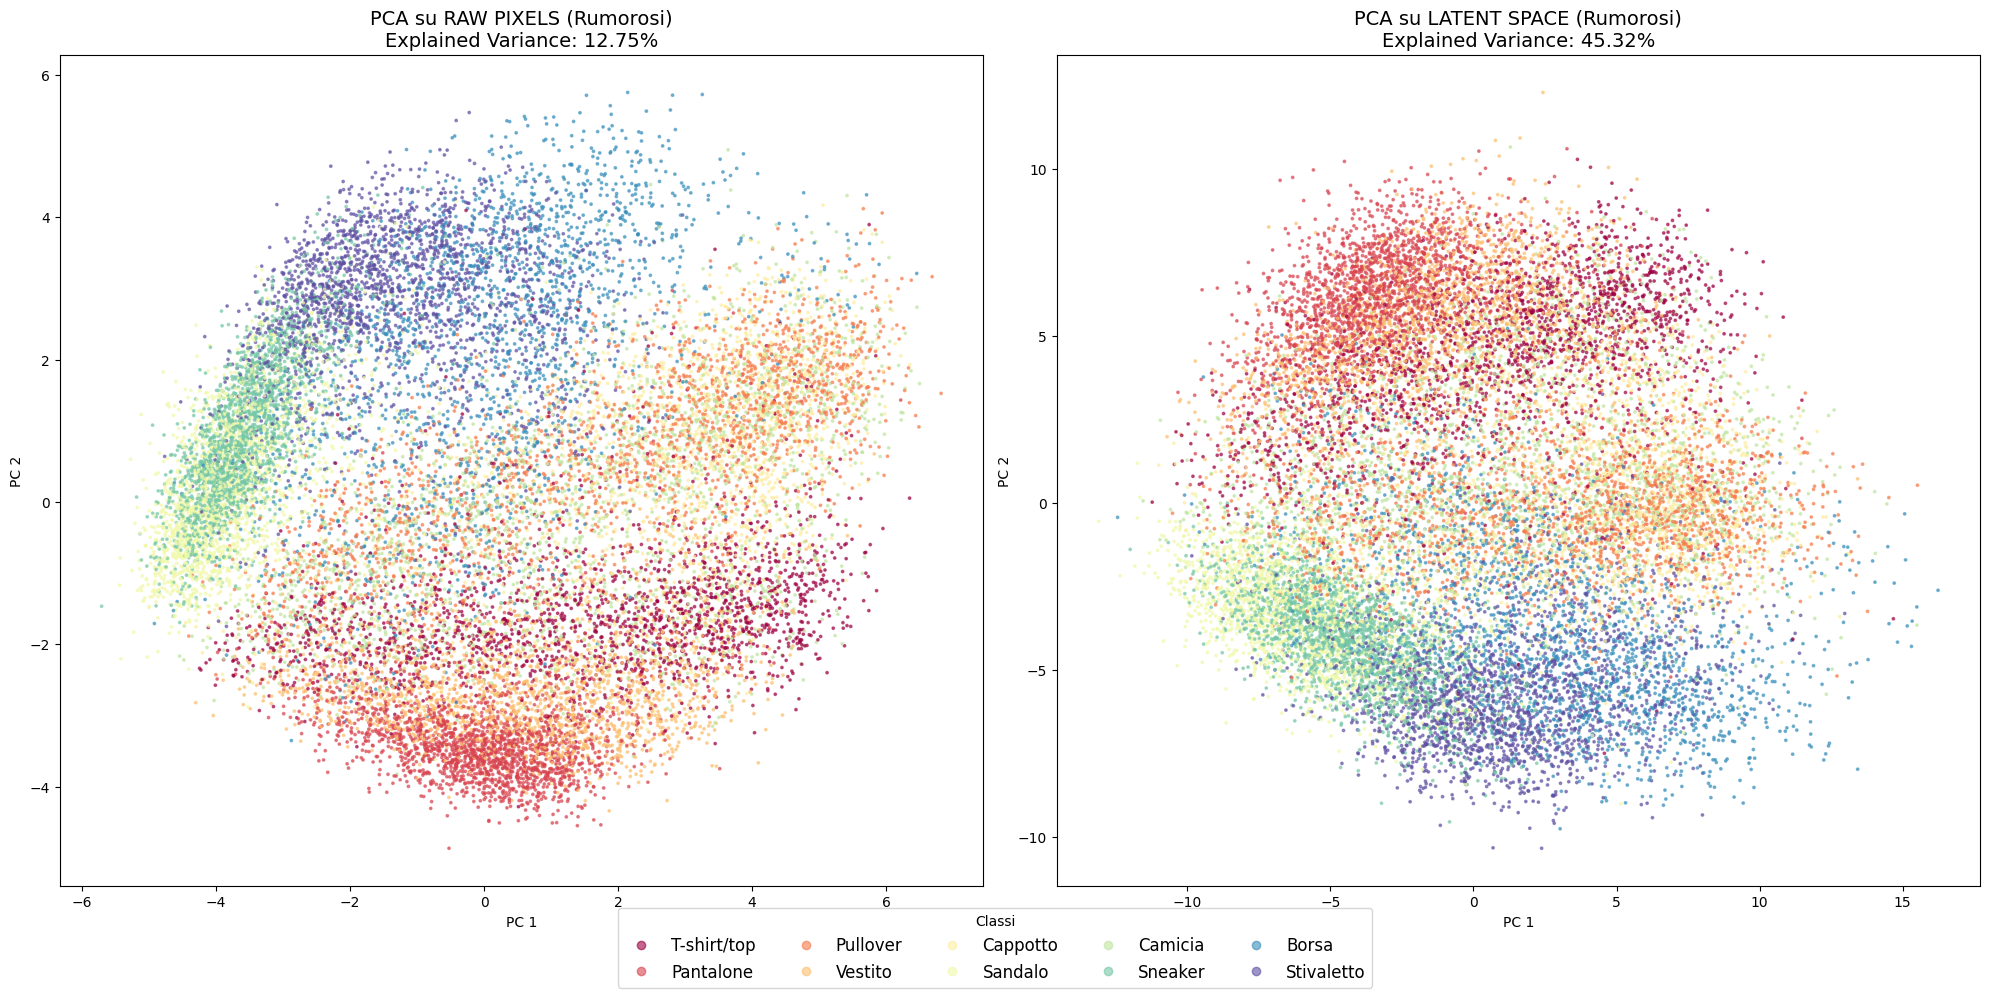

In [13]:
# =============================================================================
# BENCHMARK: PCA (Il vecchio standard)
# Vediamo se la linearità della PCA regge il confronto
# =============================================================================

from sklearn.decomposition import PCA

print("📉 Esecuzione PCA su Dati RUMOROSI...")

# 1. PCA sui Pixel Grezzi (Raw 784D + Rumore)
# (X_noisy_flat l'abbiamo creato nella cella precedente)
print("1️⃣ PCA su Raw Pixels...")
pca_raw = PCA(n_components=2)
embedding_pca_raw = pca_raw.fit_transform(X_noisy_flat)

# 2. PCA sullo Spazio Latente (32D + Rumore filtrato dall'AE)
# (X_latent_noisy l'abbiamo creato nella cella precedente)
print("2️⃣ PCA su Latent Space...")
pca_latent = PCA(n_components=2)
embedding_pca_latent = pca_latent.fit_transform(X_latent_noisy)

# 3. Visualizzazione
print("🎨 Disegno il confronto PCA...")
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot PCA RAW
scatter1 = axes[0].scatter(
    embedding_pca_raw[:, 0], 
    embedding_pca_raw[:, 1], 
    c=y_sample, 
    cmap='Spectral', 
    s=3, 
    alpha=0.6
)
axes[0].set_title(f'PCA su RAW PIXELS (Rumorosi)\nExplained Variance: {np.sum(pca_raw.explained_variance_ratio_):.2%}', fontsize=14)
axes[0].set_xlabel('PC 1')
axes[0].set_ylabel('PC 2')

# Plot PCA LATENT
scatter2 = axes[1].scatter(
    embedding_pca_latent[:, 0], 
    embedding_pca_latent[:, 1], 
    c=y_sample, 
    cmap='Spectral', 
    s=3, 
    alpha=0.6
)
axes[1].set_title(f'PCA su LATENT SPACE (Rumorosi)\nExplained Variance: {np.sum(pca_latent.explained_variance_ratio_):.2%}', fontsize=14)
axes[1].set_xlabel('PC 1')
axes[1].set_ylabel('PC 2')

# Legenda
handles, _ = scatter2.legend_elements(prop="colors")
legend_labels = [LABELS_MAP[i] for i in range(len(handles))]
fig.legend(handles, legend_labels, loc='lower center', ncol=5, fontsize=12, title="Classi")

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()